This assignment is inspired by: 

- https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression
- https://www.kaggle.com/code/dansbecker/xgboost/notebook

In this assignment we will apply XGBoost Regression techniques to predict house prices, based on the famous Kaggle Dataset https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Step 1 is to download the dataset.

In [1]:
#=========================================================================
# load up the libraries
#=========================================================================
import pandas  as pd
import numpy   as np
import xgboost as xgb

#=========================================================================
# read in the data
#=========================================================================
train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv',index_col=0)
test_data  = pd.read_csv('house-prices-advanced-regression-techniques/test.csv',index_col=0)

### <center style="background-color:Gainsboro; width:60%;">Feature selection</center>
The purpose of feature selection, as the name suggests, is to only model the most pertinent and important features, thus reducing the computational overhead, and also to alleviate the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). The following are a number of notebooks covering techniques to achieve said goal, all of which use the House Prices data as an example:

* [Feature selection using the Boruta-SHAP package](https://www.kaggle.com/carlmcbrideellis/feature-selection-using-the-boruta-shap-package)
* [Recursive Feature Elimination (RFE) example](https://www.kaggle.com/carlmcbrideellis/recursive-feature-elimination-rfe-example)
* [House Prices: Permutation Importance example](https://www.kaggle.com/carlmcbrideellis/house-prices-permutation-importance-example)
* [Feature importance using the LASSO](https://www.kaggle.com/carlmcbrideellis/feature-importance-using-the-lasso)

In this assignment, we shall use all of the numerical columns, and ignore the categorical features. To encode the categorical features one can use for example [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). 

Our first task is to do Feature Exploration and Selection. 

In [2]:
## Do your work here

# Basic Exploration
print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)

target = 'SalePrice'

#===========================================================================
#===========================================================================
X_train = train_data.select_dtypes(include=['number']).copy()
X_train = X_train.drop([target], axis=1)
y_train = train_data[target]
X_test = test_data.select_dtypes(include=['number']).copy()

#===========================================================================
# simple preprocessing: imputation; substitute any 'NaN' with mean value
#===========================================================================
X_train = X_train.fillna(X_train.mean())
X_test  = X_test.fillna(X_test.mean())


Shape of train_data: (1460, 80)
Shape of test_data: (1459, 79)


### <center style="background-color:Gainsboro; width:60%;">Feature engineering</center>
As mentioned, one aspect of feature engineering is the creation of new features out of existing features. A simple example would be to create a new feature which is the sum of the number of bathrooms in the house:

In [3]:
for df in (X_train, X_test):
    df["n_bathrooms"] = df["BsmtFullBath"] + (df["BsmtHalfBath"]*0.5) + df["FullBath"] + (df["HalfBath"]*0.5)
    df["area_with_basement"] = df["GrLivArea"] + df["TotalBsmtSF"]
    

Your next task is to apply some feature engineering to prepare for using the XGBoost Estimator to predict house prices.

In [4]:
# Code goes here

# Feature Engineering
for df in (X_train, X_test):
    # Total number of bathrooms
    df['TotalBath'] = df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']) + df['FullBath'] + (0.5 * df['HalfBath'])
    
    # Total living area (above and below ground)
    df['TotalLivArea'] = df['GrLivArea'] + df['TotalBsmtSF']
    
    # Age of the house at the time of sale
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    
    # Total porch area
    df['TotalPorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    
    # Total number of rooms (excluding bathrooms)
    df['TotalRooms'] = df['TotRmsAbvGrd'] - (df['FullBath'] + df['HalfBath'])
    

For more on this fascinating aspect may I recommend the free on-line book ["*Feature Engineering and Selection: A Practical Approach for Predictive Models*"](http://www.feat.engineering/) by Max Kuhn and Kjell Johnson.
### <center style="background-color:Gainsboro; width:60%;">XGBoost estimator</center>
Note that for this competition we use the RMSLE evaluation metric, rather than the default metric, which for regression is the RMSE. For more on the peculiarities of the RMSLE see the Appendix below.

In [5]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
regressor=xgb.XGBRegressor(eval_metric='rmsle')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}


Can you use grid search to find the optimal hyper parameters?

In [6]:
## Put code here

# Initialize grid search with the regressor, parameter grid, and cross-validation
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_log_error', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Initialize the best regressor with the best parameters
best_regressor = xgb.XGBRegressor(eval_metric='rmsle', **grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [7]:
# Get the best parameters from the grid search
print("The best hyperparameters are ",grid_search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700}


Now, can you setup a XGBoost Regressor object using your hyperparameters and fit it?

In [8]:
# Put code here

# Fit the best regressor to the full training data
best_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Finally, can you run it on your test set?

In [9]:
# Put code here

# Predict the prices for the test data
y_pred = best_regressor.predict(X_test)

# Create an offline solution file
my_pred = pd.DataFrame({'Id': test_data.index, 'SalePrice': y_pred})
my_pred.to_csv('my_pred.csv', index=False)

Can you score your solution offline and see how it does?

In [10]:
# read in the ground truth file
solution = pd.read_csv('my_pred.csv')
y_true = solution["SalePrice"]

from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_true, y_pred) )
print("The score is %.5f" % RMSLE )

The score is 0.00000


Finally, use the below block to prepare your submission

In [11]:
output = pd.DataFrame({"Id":test_data.index, "SalePrice":y_pred})
output.to_csv('submission.csv', index=False)

### <center style="background-color:Gainsboro; width:60%;">Feature importance</center>
Let us also take a very quick look at the feature importance too:

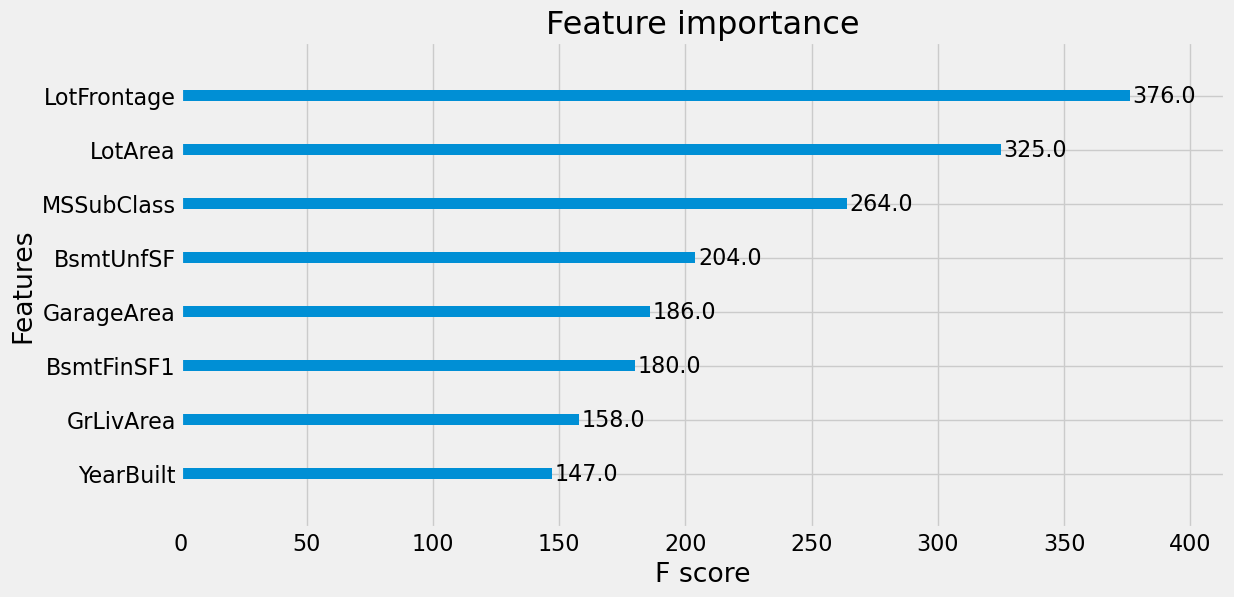

In [12]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Fit the regressor to the training data
regressor.fit(X_train, y_train)

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

# Then plot the feature importances
fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show();

Where here the `F score` is a measure "*...based on the number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees*." [1] 

Note that these importances are susceptible to small changes in the training data, and it is much better to make use of ["GPU accelerated SHAP values"](https://www.kaggle.com/carlmcbrideellis/gpu-accelerated-shap-values-jane-street-example), incorporated with version 1.3 of XGBoost.

Can you follow the above guide use SHAP values instead of F Score?

In [13]:
# !pip install shap

# !pip -q install xgboost --upgrade
import xgboost as xgb

# check that we have installed version 1.3.1
xgb.__version__

'2.0.0'

XGBoost

In [14]:
n_trees = 500
dmat = xgb.DMatrix(X_train, y_train)
bst  = xgb.train({"tree_method": "gpu_hist"}, dmat, n_trees)
# Make sure GPU prediction is enabled
bst.set_param({"predictor": "gpu_predictor"})

C:\Users\ntnt3\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [04:33:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


SHAP values

In [15]:
%%time 

# Compute the shap values
shap_values = bst.predict(dmat, pred_contribs=True)

CPU times: total: 500 ms
Wall time: 47.7 ms


C:\Users\ntnt3\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [04:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\ntnt3\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:160: UserWarning: [04:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


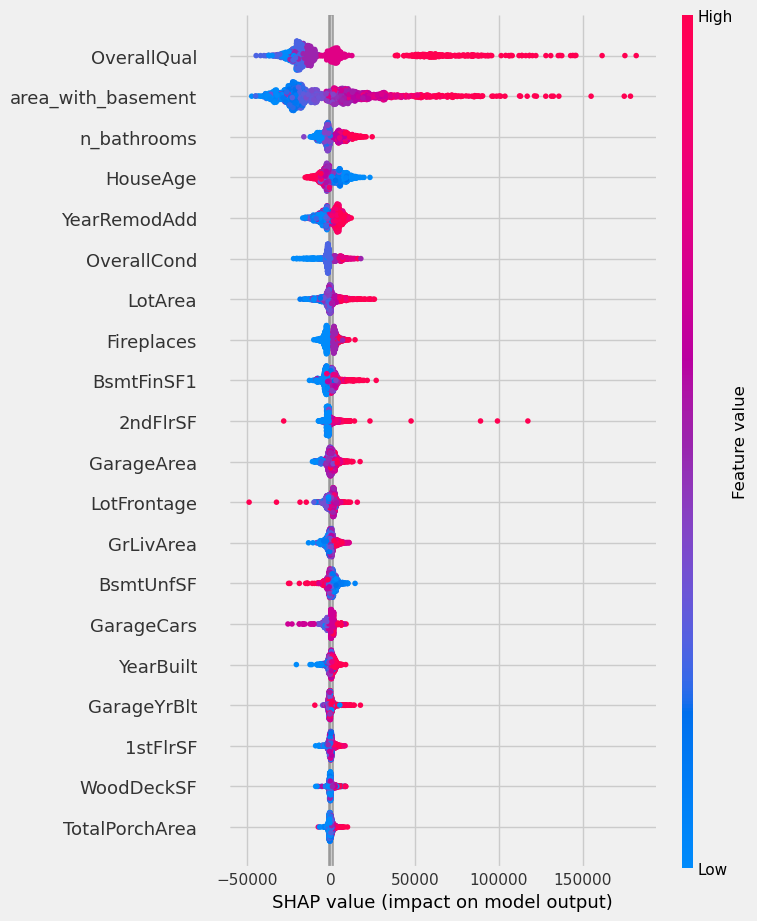

In [16]:
import shap

# and plot
shap.summary_plot(shap_values[:,:-1], X_train)

SHAP interactions

In [17]:
%%time 

# Compute the shap interactions
shap_interactions = bst.predict(dmat, pred_interactions=True)

CPU times: total: 109 ms
Wall time: 248 ms


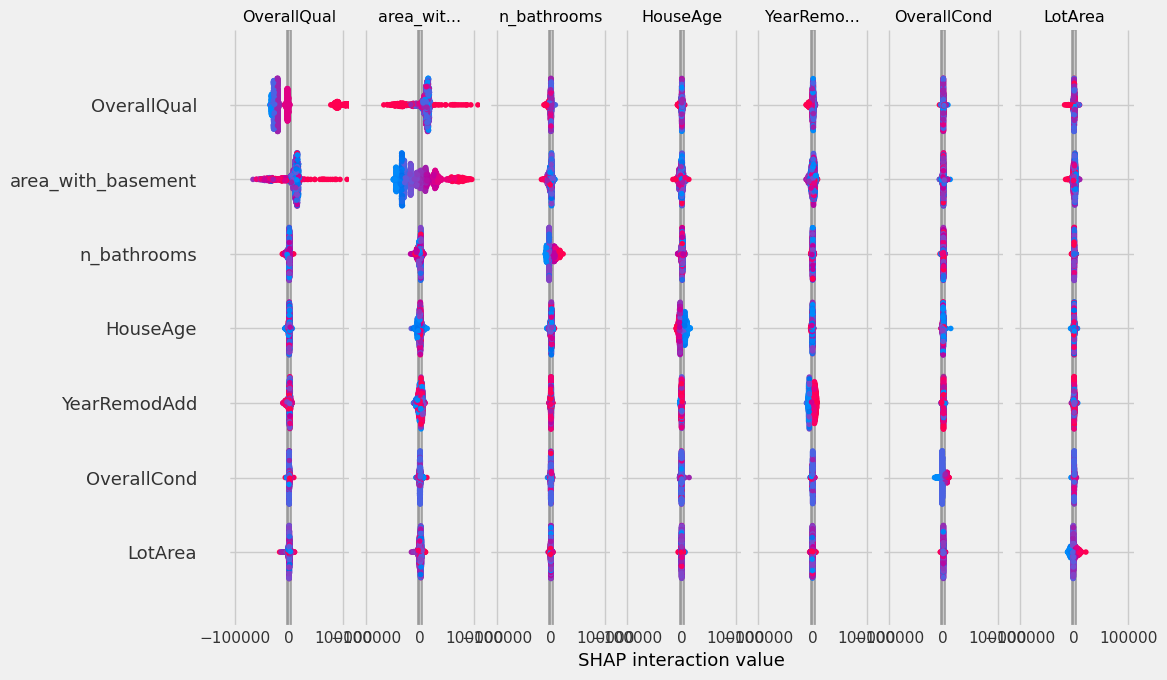

In [18]:
# and plot
import matplotlib.pyplot as plt

# Set text size
plt.rcParams.update({'font.size': 8})

# Plot
shap.summary_plot(shap_interactions[:,:-1,:-1], X_train, plot_size=(12,8))

### <center style="background-color:Gainsboro; width:60%;">Appendix: The RMSLE evaluation metric</center>
From the competition [evaluation page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) we see that the metric we are using is the root mean squared logarithmic error (RMSLE), which is given by

$$ {\mathrm {RMSLE}}\,(y, \hat y) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $$

where $\hat{y}_i$ is the predicted value of the target for instance $i$, and $y_i$
is the actual value of the target for instance $i$.

It is important to note that, unlike the RMSE, the RMSLE is asymmetric; penalizing much more the underestimated predictions than the overestimated predictions. For example, say the correct value is $y_i = 1000$, then underestimating by 600 is almost twice as bad as overestimating by 600:

In [19]:
def RSLE(y_hat,y):
    return np.sqrt((np.log1p(y_hat) - np.log1p(y))**2)

print("The RMSLE score is %.3f" % RSLE( 400,1000) )
print("The RMSLE score is %.3f" % RSLE(1600,1000) )

The RMSLE score is 0.915
The RMSLE score is 0.470


The asymmetry arises because 

$$ \log (1 + \hat{y}_i) - \log (1 + y_i) =  \log \left( \frac{1 + \hat{y}_i}{1 + y_i} \right) $$

so we are essentially looking at ratios, rather than differences such as is the case of the RMSE. We can see the form that this asymmetry takes in the following plot, again using 1000 as our ground truth value:

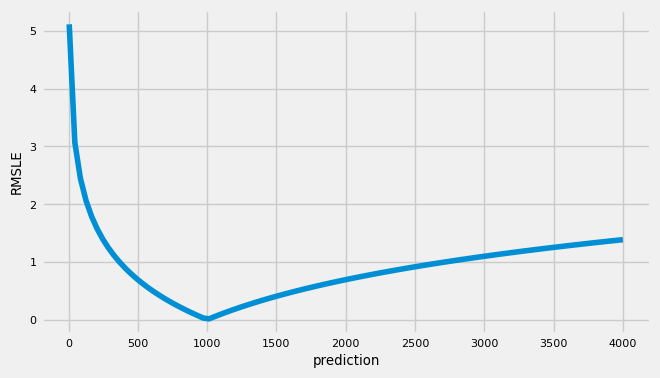

In [20]:
plt.rcParams["figure.figsize"] = (7, 4)
x = np.linspace(5,4000,100)
plt.plot(x, RSLE(x,1000))
plt.xlabel('prediction')
plt.ylabel('RMSLE')
plt.show()